## FaceForensics++

In this notebook we show the results for FaceForensics++. You can create from scratch the features or use the pre-computed ones.

### 1. Create feature

If you want to create the features, first of all download the "prepro_deepFake" folder from [link](https://bit.ly/2wkPZYv). Be sure to save the folder together with this notebook. 

Otherwise, just jump to section 2.

In [1]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
N = 300
y = []
error = []


number_iter = 1600

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = 'prepro_deepFake/fake/'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:        

        filename = os.path.join(subdir, file)
        
        img = cv2.imread(filename,0)
        
        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)

        magnitude_spectrum = 20*np.log(np.abs(fshift))
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

        # Calculate the azimuthally averaged 1D power spectrum
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total[cont,:] = interpolated             
        label_total[cont] = 0
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break
            
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])


## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)


cont = 0
rootdir2 = 'prepro_deepFake/real/'

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:        

        filename = os.path.join(subdir, file)
        parts = filename.split("/")
   
        img = cv2.imread(filename,0)
    
        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon


        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total2[cont,:] = interpolated             
        label_total2[cont] = 1
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    
    
y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('train_3200.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 

DATA Saved


### 2. Loading Features

Now, we load the features. Either the pre-computed ones or the features that you have created.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

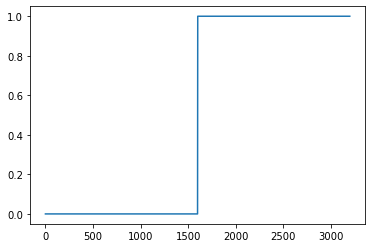

In [3]:
plt.plot(y)

### 3. Check Spectrum

We havw a look to the spectrum

Text(0, 0.5, 'Power Spectrum')

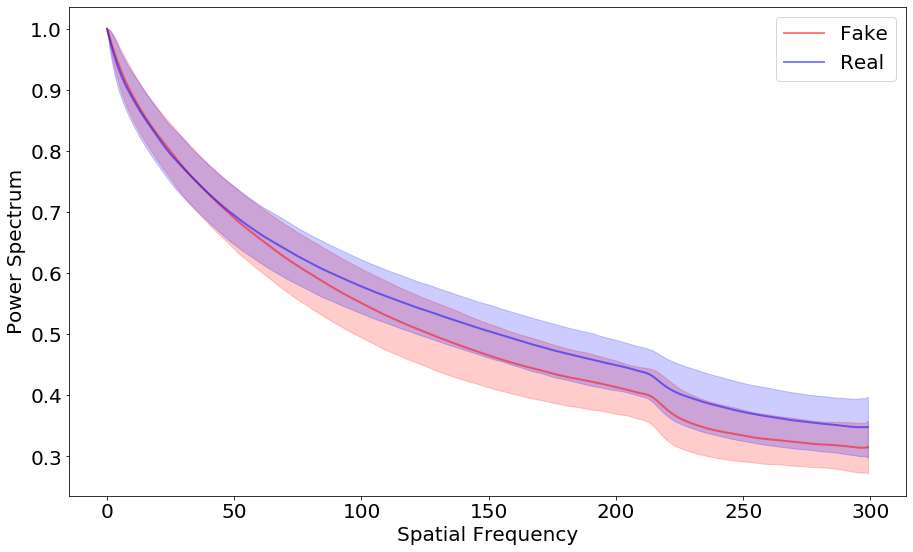

In [4]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

### 4. Classification

Now we classify using the features.

In [9]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle

#train
pkl_file = open('train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
svclassifier_r.fit(X, y)
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X, y)

#test
pkl_file = open('test_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_ = data["data"]
y_ = data["label"]

SVM = svclassifier_r.score(X_, y_)
LR = logreg.score(X_, y_)


print("SVM: "+str(SVM))
print("LR: "+str(LR))

SVM: 0.8605
LR: 0.7865
